### **Case Study: "Political Prediction"**

### 1. Frame the Problem

Our data set contains agreement from different parties on various political
statements. The statements were used in the so-called Wahl O mat (election mat) to query the political opinion of individuals and to match it with the political party's election programme/opinion.
The task for this homework is to train classifier that can predict one of the following parties’ position (0 vs. 1): SPD, CDU, FDP, Die Linke. To complete this assignment I will focus on the SPD and train models accordingly

### 2. Get the Data

**Import libraries**

In [1]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('german')
from nltk.tokenize import word_tokenize 
import re
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbandmann\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbandmann\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


**Import data**

In [2]:
path ='your path here'
df = pd. read_csv(path+'PolPred_Data.csv')

### 3. Explore the Data

In [3]:
#head of the dataset
df.head()
#tail of dataset
df.tail()
#shape of dataset
df.shape
#information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Columns: 147 entries, statement to wir2020
dtypes: float64(139), int64(6), object(2)
memory usage: 2.3+ MB


**Preprocessing the data**

In [4]:
# Code to lowercase
df['text']=df['text'].str.lower()
# Code to remove the Hashtags from the text
df['text']=df['text'].apply(lambda x:re.sub(r'\B#\S+','',str(x)))
# Code to remove the links from the text
df['text']=df['text'].apply(lambda x:re.sub(r"http\S+", "", str(x)))
# Code to remove the Special characters from the text 
df['text']=df['text'].apply(lambda x:' '.join(re.findall(r'\w+', str(x))))
# Code to substitute the multiple spaces with single spaces
df['text']=df['text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Code to remove all the single characters in the text
df['text']=df['text'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove the @ 
df['text']=df['text'].apply(lambda x:re.sub('@[^\s]+','',x))

**Removing stopwords**

All frequencies, including STOPWORDS:
        Word  Frequency
0     sollen        666
1  weiterhin        181
2       land        175
3     dürfen        157
4       mehr        104
5   erhalten         99
6  einsetzen         95
7         eu         88
8    sachsen         82
9    schulen         78


<AxesSubplot:xlabel='Word'>

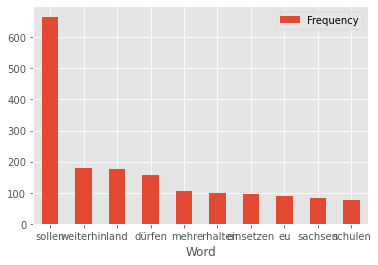

In [9]:

top_N = 10

df['text']=df['text'].astype(str)
txt = df.text.str.lower().str.replace(r'\|', ' ', regex=True).str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('german')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')

rslt.plot.bar(rot=0)

**Tokenization**

In [6]:
df['text'].apply(word_tokenize)

0       [haschisch, und, marihuana, sollen, legalisier...
1       [die, bundeswehr, soll, die, polizei, innerhal...
2       [die, geschäfte, sollen, am, sonntag, geöffnet...
3       [die, humane, genomforschung, soll, verboten, ...
4                 [kampfhunde, sollten, verboten, werden]
                              ...                        
2016    [das, land, soll, mehr, finanzielle, mittel, f...
2017    [die, gebühren, für, ein, zweitstudium, sollen...
2018    [die, arbeitsbedingungen, in, betrieben, mit, ...
2019    [sachsen, anhalt, soll, die, begrenzung, der, ...
2020    [sachsen, anhalt, soll, spätestens, 2035, klim...
Name: text, Length: 2021, dtype: object

**Removing Stop Words**

In [7]:
df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stop])
df['text']

0             [haschisch, marihuana, sollen, legalisiert]
1       [bundeswehr, polizei, innerhalb, deutschlands,...
2                  [geschäfte, sollen, sonntag, geöffnet]
3                      [humane, genomforschung, verboten]
4                         [kampfhunde, sollten, verboten]
                              ...                        
2016    [land, mehr, finanzielle, mittel, frauenhäuser...
2017    [gebühren, zweitstudium, sollen, sachsen, anha...
2018    [arbeitsbedingungen, betrieben, saisonarbeitsk...
2019    [sachsen, anhalt, begrenzung, neuverschuldung,...
2020    [sachsen, anhalt, spätestens, 2035, klimaneutral]
Name: text, Length: 2021, dtype: object

In [8]:
#convert the datafram to string
df['text']=df['text'].apply(lambda x: ' '.join(x))
df['text']

0                  haschisch marihuana sollen legalisiert
1       bundeswehr polizei innerhalb deutschlands unte...
2                       geschäfte sollen sonntag geöffnet
3                          humane genomforschung verboten
4                             kampfhunde sollten verboten
                              ...                        
2016    land mehr finanzielle mittel frauenhäuser bere...
2017    gebühren zweitstudium sollen sachsen anhalt ab...
2018    arbeitsbedingungen betrieben saisonarbeitskräf...
2019    sachsen anhalt begrenzung neuverschuldung schu...
2020          sachsen anhalt spätestens 2035 klimaneutral
Name: text, Length: 2021, dtype: object

### 4. Prepare the Data

**Split the dataset to test and train**

In [26]:
#drop the neutral row(you may also decide to exclude this neutral class and train only a binary classifier: agreement vs. disagreement)
df.drop(df[df['spd'] == 2].index, inplace = True)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['spd'],test_size=0.20, random_state=5)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

### 5. Shortlist Promising Models

In [29]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

**Naive bayes**

Accuracy: 69.53%
Precision: 69.58%
Recall: 67.61%
F1 Score:  0.6774062520309352


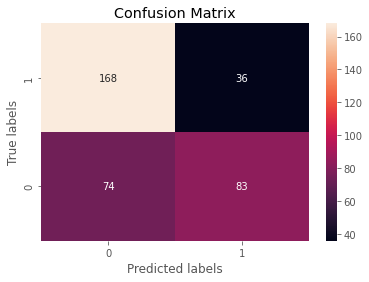

In [15]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
acc_score = metrics.accuracy_score(predictions_NB,y_test)
#Measure Precission
prec_score = precision_score(y_test,predictions_NB, average='macro')
#Measure Recall
recall = recall_score(y_test, predictions_NB,average='macro')
#Measure F1 Score
f1 = f1_score(y_test,predictions_NB,average='macro')
#confusion Matrix
matrix = confusion_matrix(y_test,predictions_NB)

#Print Accuracy
print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
#Print Precission
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
# Print Recall
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
#Print F1 Score
print('F1 Score: ',f1)
#Draw confusion Matrix
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([1, 0]);

**SVM MODEL**

Accuracy: 71.75%
Precision: 73.83%
Recall: 69.06%
F1 Score:  0.690238239450838


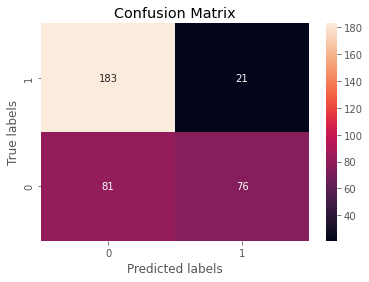

In [16]:
SVM = svm.SVC()
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
acc_score = metrics.accuracy_score(predictions_SVM ,y_test)
#Measure Precission
prec_score = precision_score(y_test,predictions_SVM , average='macro')
#Measure Recall
recall = recall_score(y_test, predictions_SVM ,average='macro')
#Measure F1 Score
f1 = f1_score(y_test,predictions_SVM ,average='macro')
matrix = confusion_matrix(y_test,predictions_SVM)

#Print Accuracy
print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
#Print Precission
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
# Print Recall
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
#Print F1 Score
print('F1 Score: ',f1)
#Draw confusion Matrix
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([1, 0]);

### 6. Fine-tune the System

**OverSample The Data**

<AxesSubplot:xlabel='spd', ylabel='count'>

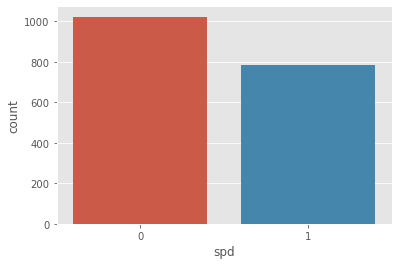

In [21]:
import seaborn as sc
sc.countplot(data = df, x= 'spd')

In [22]:
# Class count
count_class_0, count_class_1 = df.spd.value_counts()

# Divide by class
df_class_0 = df[df['spd'] == 0]
df_class_1 = df[df['spd'] == 1]

# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_test_over['text'],df_test_over['spd'],test_size=0.2, random_state=5)

from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

**Result of NB**

Accuracy: 77.75%
Precision: 77.79%
Recall: 77.89%
F1 Score:  0.7773730268391743


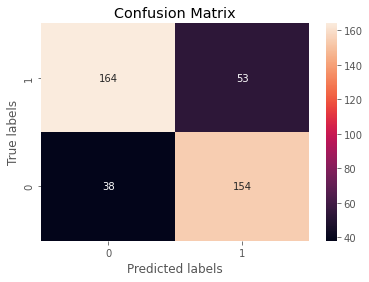

In [24]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
acc_score = metrics.accuracy_score(predictions_NB,y_test)
#Measure Precission
prec_score = precision_score(y_test,predictions_NB, average='macro')
#Measure Recall
recall = recall_score(y_test, predictions_NB,average='macro')
#Measure F1 Score
f1 = f1_score(y_test,predictions_NB,average='macro')
#confusion Matrix
matrix = confusion_matrix(y_test,predictions_NB)

#Print Accuracy
print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
#Print Precission
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
# Print Recall
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
#Print F1 Score
print('F1 Score: ',f1)
#Draw confusion Matrix
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([1, 0]);

**SVM MODEL**

Accuracy: 85.82%
Precision: 86.25%
Recall: 85.47%
F1 Score:  0.8564530183472916


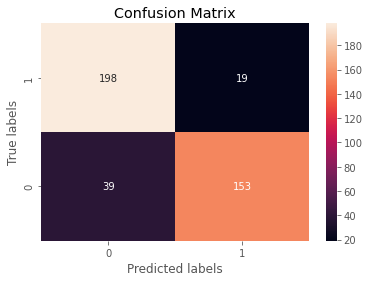

In [25]:
SVM = svm.SVC()
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
acc_score = metrics.accuracy_score(predictions_SVM ,y_test)
#Measure Precission
prec_score = precision_score(y_test,predictions_SVM , average='macro')
#Measure Recall
recall = recall_score(y_test, predictions_SVM ,average='macro')
#Measure F1 Score
f1 = f1_score(y_test,predictions_SVM ,average='macro')
matrix = confusion_matrix(y_test,predictions_SVM)

#Print Accuracy
print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
#Print Precission
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
# Print Recall
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
#Print F1 Score
print('F1 Score: ',f1)
#Draw confusion Matrix
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([1, 0]);

### 7. Solution

In my comparison the Support Vector Machine has always performed better than the naive bayes classifier, no matter with or without fine tuning. The fine tuning was able to boost the accurcay by 10 % to approx 84%. In the fine tuning section I adjusted the dataset to balanced calss with the same amount of agreement and disagreements.
In my opinion, an adequate number of models were trained and compared with each other. Unfortunately, I did not succeed in using the pre-trained Bert-base-cased model based from the 'hugging face' website. In addition, the management of libraries was very challenging and problematic, as different packages were not compatible with each other. Due to the selection of my models, I did not experience any problems with my system performance. If I had more time, I would have added LDA analysis and topic clustering to the data exploration section. Furthermore, I would expand the selection of my models and incorporate also neuronal networks. Finally it would be nice to fine tune some hyperparameter but this was beyond my knowledge.
